In [1]:
import numpy as np
from matplotlib import pyplot as plt

from synet.networks import random_network
from synet.process import DelayProcess, DiseaseProcess, MajorityProcess, PredatorProcess
from synet.utils import apply_process, apply_measures
from synet.visualization import plot_process_results, plot_measure_results
from synet.visualization import plot_process_v_measure, plot_pvm_dt, plot_measure_v_process

In [24]:
n_networks = 300
process_dt = 250
n_events = 5000
np.random.seed(1298734)

In [3]:
processes = {
    "delay": {"process": DelayProcess(), "n_sim": 10000, "n_jobs": 32},
    "majority": {"process": MajorityProcess(), "n_sim": 1000, "n_jobs": 32},
    "disease": {"process": DiseaseProcess(), "n_sim": 1000, "n_jobs": 32},
    "predator": {"process": PredatorProcess(), "n_sim": 2000, "n_jobs": 32},
}

In [4]:
%%time
networks = [random_network(n_events=n_events) for _ in range(n_networks)]

CPU times: user 41.4 s, sys: 0 ns, total: 41.4 s
Wall time: 41.5 s


In [5]:
%%time
process_results = {}
for name, process_args in processes.items():
    res = apply_process(networks, dt=process_dt, **process_args)
    process_results[name] = res


CPU times: user 2min 19s, sys: 34min 10s, total: 36min 30s
Wall time: 1h 41min 57s


In [18]:
%%time
measure_results = apply_measures(networks, max_dt=100, n_jobs=16)


CPU times: user 449 ms, sys: 11 s, total: 11.4 s
Wall time: 45 s


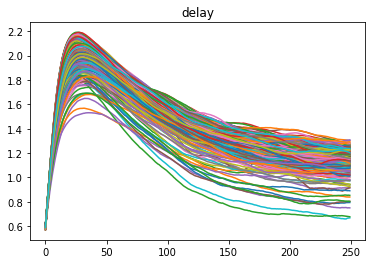

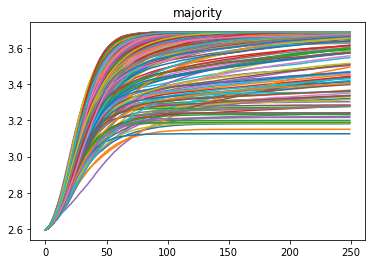

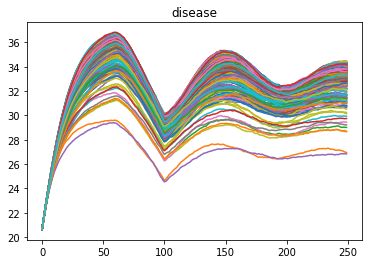

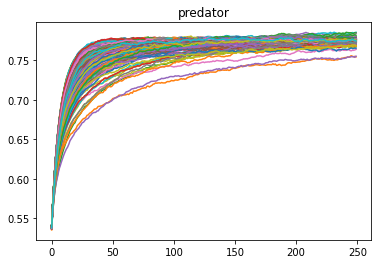

In [7]:
for name, res in process_results.items():
    plt.title(name)
    plot_process_results(res)
    

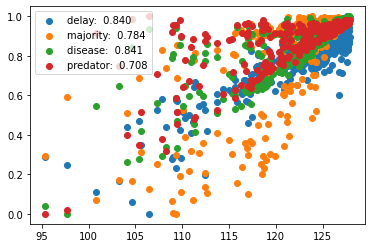

In [8]:
plot_measure_v_process(measure_results, process_results)

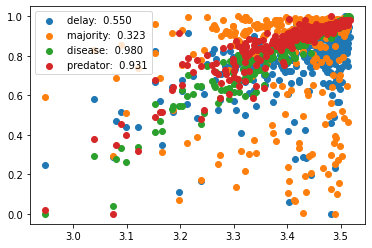

In [9]:
plot_measure_v_process(agent_results, process_results)

In [16]:
import pandas as pd

def write_csv(process_results, measure_results, fp):
    df = pd.DataFrame()
    n_network = len(process_results[list(process_results)[0]])
    df['net_id'] = np.arange(n_network)
    for name, res in process_results.items():
        df[name] = [np.mean(r) for r in res]
    for name, res in measure_results.items():
        df[name] = [np.mean(r) for r in res]
    df.to_csv(fp, index=False)
    return df

#df = write_csv(process_results, measure_results, "comparison.csv")
df = pd.read_csv("comparison.csv")
print(df)

     net_id     delay  majority    disease  predator   overlap     agent  \
0         0  1.377759  3.214978  32.597736  0.764659  0.800148  3.440294   
1         1  1.499704  3.515017  32.993532  0.767087  0.855074  3.505474   
2         2  1.258964  3.229228  31.733172  0.761199  0.746791  3.314414   
3         3  1.587946  3.556008  33.098084  0.767268  0.894885  3.508092   
4         4  1.288413  3.219144  32.470848  0.764940  0.826623  3.482658   
..      ...       ...       ...        ...       ...       ...       ...   
295     295  1.526147  3.552509  32.589828  0.764018  0.889454  3.455194   
296     296  1.483563  3.488047  32.706316  0.766326  0.827831  3.471015   
297     297  1.502109  3.476475  32.379528  0.763851  0.827758  3.414502   
298     298  1.460079  3.526235  31.543492  0.759158  0.803016  3.325071   
299     299  1.514619  3.554735  32.404820  0.763940  0.843766  3.378014   

         mixing        path       paint  
0    119.945024   98.408937  127.220703  
1  

In [59]:
from scipy.stats import spearmanr
import numpy as np
from matplotlib import pyplot as plt

In [18]:
n_list = len(list(df))

cor_matrix = np.zeros((n_list, n_list))
for i_1, name_1 in enumerate(list(df)):
    for i_2, name_2 in enumerate(list(df)):
        cor_matrix[i_1, i_2] = spearmanr(df[name_1], df[name_2]).correlation
        

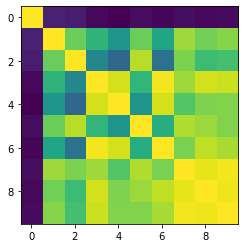

In [60]:
plt.imshow(cor_matrix)
plt.show()

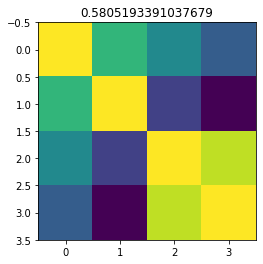

In [20]:
# Internal correlation average:

plt.imshow(cor_matrix[1:5, 1:5])
plt.title(str((np.sum(cor_matrix[1:5, 1:5])-4)/12))
plt.show()
print()

In [21]:
# measures
for col in range(5, n_list):
    avg = np.mean(cor_matrix[col, 1:5])
    print(list(df)[col], avg)


overlap 0.6864678496427737
agent 0.6960707341192679
mixing 0.7933714819053543
path 0.784651385015389
paint 0.7963929599217769


In [56]:
# processes
for col in range(1, 5):
    avg = (np.sum(cor_matrix[col, 1:5])-1)/3
    print(list(df)[col], avg)

delay 0.6202065948880913
majority 0.4813401630388485
disease 0.655438690059519
predator 0.5650919084286121


In [58]:
avg = np.zeros(n_networks)
for pr_name in list(df)[1:5]:
    order = np.argsort(df[pr_name].values)
    true_order = np.empty_like(order, dtype=int)
    true_order[order] = np.arange(len(order), dtype=int)

    avg += true_order

new_order = avg/4

corr = []
for pr_name in list(df)[1:5]:
    corr.append(spearmanr(new_order, df[pr_name].values).correlation)

print("best case:", np.mean(corr))

best case: 0.825682597271459
